# Predict rasters for a single placettes out of a parcelle

In [1]:
import warnings

warnings.simplefilter(action="ignore")

import functools
import argparse
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from torch.utils.tensorboard import SummaryWriter
from scipy.stats import gamma
import os
import time
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchnet as tnt
from sklearn.neighbors import NearestNeighbors

import gc

# from osgeo import gdal, osr  # TODO: UNCOMMENT
import torch.nn as nn
from scipy.special import digamma, polygamma

import matplotlib

# Weird behavior: loading twice in cell appears to remove an elsewise occuring error.
for i in range(2):
    try:
        matplotlib.use("TkAgg")  # rerun this cell if an error occurs.
    except:
        print("!")
import matplotlib.pyplot as plt


import pickle
from torch_scatter import scatter_max, scatter_mean

print(torch.cuda.is_available())
np.random.seed(42)
torch.cuda.empty_cache()

# We import from other files
import sys
sys.path.append("/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/")
from config import args
from model.model import PointNet
from utils.useful_functions import *
from data_loader.loader import *
from utils.load_las_data import *
from model.loss_functions import *
from model.accuracy import *
from em_gamma.get_gamma_parameters_em import *
from model.train import train_full

print("Everything is imported")


print(torch.cuda.is_available())
np.random.seed(42)
torch.cuda.empty_cache()

False
Dataset folder in use: /home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/data/
Arguments were imported in DEV mode
Everything is imported
False


# Tests with Shapely

In [2]:
# # Test from https://gis.stackexchange.com/a/192669/184486
# import shapely
# from shapely.geometry import Point
# # idx_center = 0
# # disk = Point([15,17]).buffer(10)
# # other_point = Point([15,17+9.99999])
# # other_point.within(disk)

In [3]:
# # Test from https://gis.stackexchange.com/a/327680/184486
# from shapely.prepared import prep
# from shapely.geometry import asMultiPoint

# radius = 10
# center = Point([15,17])
# prepped_buffer = prep(center.buffer(radius))
# two_points = [[16,17+9], [16,17+11]]
# points = asMultiPoint(two_points)
# # boolean array indicating what points were contained within distance from the line
# contained = np.fromiter(map(prepped_buffer.contains, points), np.bool)
# # take all rows from all_objs that are within distance from line
# contained_points = np.compress(contained, two_points, axis=0)
# result

# infer.py

In [ ]:
%load_ext autoreload
%autoreload 2

In [10]:
import warnings

warnings.simplefilter(action="ignore")

import numpy as np
import os
import torch
import torchnet as tnt
import torch.nn as nn
import matplotlib

# Weird behavior: loading twice in cell appears to remove an elsewise occuring error.
for i in range(2):
    try:
        matplotlib.use("TkAgg")  # rerun this cell if an error occurs.
    except:
        print("!")

print(torch.cuda.is_available())
np.random.seed(42)
torch.cuda.empty_cache()

# We import from other files
from utils.useful_functions import *
from data_loader.loader import *
from utils.load_las_data import load_all_las_from_folder, open_metadata_dataframe
from model.loss_functions import *
from model.accuracy import *
from em_gamma.get_gamma_parameters_em import *
from model.model import PointNet
from utils.point_cloud_classifier import PointCloudClassifier
from model.infer_utils import (
    divide_parcel_las_and_get_disk_centers,
    extract_points_within_disk,
    create_geotiff_raster,
)
from utils.reproject_to_2d_and_predict_plot_coverage import project_to_2d


from config import args

args.z_max = 24.14  # the TRAINING args should be loaded !


print("Everything is imported")

print(torch.cuda.is_available())
np.random.seed(42)
torch.cuda.empty_cache()

# Create the result folder
create_new_experiment_folder(args, infer_mode=True)  # new paths are added to args
las_folder = args.las_parcelles_folder_path
las_filenames = os.listdir(las_folder)


# define the classifier
model = torch.load(args.trained_model_path)
print(f"trained model was loaded from {args.trained_model_path}")
model.eval()
# load the model
# print(
#     "Total number of parameters: {}".format(
#         sum([p.numel() for p in model.parameters()])
#     )
# )
# print(model)
PCC = PointCloudClassifier(args)

for las_filename in las_filenames:
    if args.mode == "DEV":
        if las_filename != "004000715-5-18.las":
            continue
    # her we divide all parcels into plots
    grid_pixel_xy_centers, points_nparray = divide_parcel_las_and_get_disk_centers(
        args, las_folder, las_filename, save_fig_of_division=True
    )

    # TODO: replace this loop by an ad-hoc DataLoader

    for plot_center in grid_pixel_xy_centers:
        contained_points_nparray = extract_points_within_disk(
            points_nparray, plot_center
        )
        # infer if non-empty selection
        if contained_points_nparray.shape[0] > 0:
            las_id = las_filename.split(".")[0]

            # TODO: remove print
            print(contained_points_nparray.shape)
            contained_points_nparray = contained_points_nparray.transpose()
            contained_points_nparray = normalize_cloud_data(
                contained_points_nparray, args
            )

            # add a batch dim before trying out dataloader
            contained_points_nparray = np.expand_dims(contained_points_nparray, axis=0)
            contained_points_tensor = torch.from_numpy(contained_points_nparray)

            # infer
            model.eval()
            # compute pointwise prediction
            pred_pointwise, _ = PCC.run(model, contained_points_tensor)

            # pred_pointwise was permuted from (scores_nb, pts_nb) to (pts_nb, scores_nb) for some reasons at the end of PCC.run
            pred_pointwise = pred_pointwise.permute(1, 0)
            create_geotiff_raster(
                args,
                pred_pointwise,
                contained_points_tensor,
                plot_center,
                las_id,
                add_weights_band=False,
            )
            break


False
Everything is imported
False
14:31:38
Results folder:  /home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/experiments/RESULTS_3_strata/only_stratum/DEV/inference/2021-06-03_16h31m38s/
trained model was loaded from /home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/experiments/RESULTS_3_strata/only_stratum/PROD/2021-05-31_11h40m21s/model_ss_4096_dp_32_fold_1.pt
Square dimensions are 14.14m*14.14mbut we move 11.02m at a time to have 3.12m of overlap
(999, 9)


RuntimeError: shape '[2, 1]' is invalid for input of size 999

In [13]:
import numpy as np
np.linspace(0,32,33)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32.])

<IPython.core.display.Javascript object>


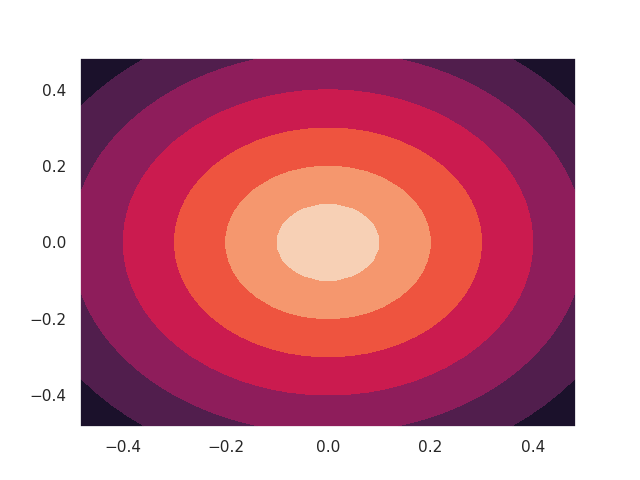

In [41]:
%matplotlib notebook
import matplotlib.pyplot as plt

x = (np.arange(-16, 16, 1)+0.5)/32
y = (np.arange(-16, 16, 1)+0.5)/32

xx, yy = np.meshgrid(x, y, sparse=True)
z = 1-np.sqrt(xx**2 + yy**2)
h = plt.contourf(x,y,z)
plt.show()

In [42]:
x

array([-0.484375, -0.453125, -0.421875, -0.390625, -0.359375, -0.328125,
       -0.296875, -0.265625, -0.234375, -0.203125, -0.171875, -0.140625,
       -0.109375, -0.078125, -0.046875, -0.015625,  0.015625,  0.046875,
        0.078125,  0.109375,  0.140625,  0.171875,  0.203125,  0.234375,
        0.265625,  0.296875,  0.328125,  0.359375,  0.390625,  0.421875,
        0.453125,  0.484375])

In [31]:
z.shape

(32, 32)